# Route Identification Over Time

Recent observations shows small chages in routes over time. Specifically in the following fields:
* route ID
* route short name
* route long name
* route desc

Need to observe these route changes in order to account for these changes in future analyses.

## Objective
1. Query data from `fct_monthly_routes` to help identify variences in Routes. Query for 2023, a couple of months. 
2. Save data to GCS `gtfs_schedule` bucket
3. Filter down data to `Sacramento Regional Transit`, identify and observe routes for any variences


## function from `open_data/download_vehicle_position.py`
    
    import datetime
    import gcsfs
    import geopandas as gpd
    import pandas as pd
    import shapely
    import sys

    from calitp_data_analysis.tables import tbls
    from calitp_data_analysis import utils
    from loguru import logger
    from siuba import *

    from shared_utils import schedule_rt_utils
    
    def download_vehicle_positions(
        date: str,
        operator_names: list
    ) -> pd.DataFrame:    
    
        df = (tbls.mart_gtfs.fct_vehicle_locations()
              >> filter(_.service_date == date)
              >> filter(_.gtfs_dataset_name.isin(operator_names))
              >> select(_.gtfs_dataset_key, _.gtfs_dataset_name,
                        _.schedule_gtfs_dataset_key,
                        _.trip_id, _.trip_instance_key,
                        _.location_timestamp,
                        _.location)
                  >> collect()
             )

In [1]:
#imports copied from download_vehicle_position.py script

import datetime
import gcsfs
import geopandas as gpd
import pandas as pd
import shapely
import sys

from calitp_data_analysis.tables import tbls
from calitp_data_analysis import utils
from loguru import logger
from siuba import *

from shared_utils import schedule_rt_utils
from shared_utils import geography_utils

In [2]:
# test to query fct_monthly_routes
def get_monthly_routes(
        year: str,
        months: list
    ) -> pd.DataFrame:    
    
        df = (tbls.mart_gtfs.fct_monthly_routes()
              >> filter(_.year == year)
              >> filter(_.month.isin(months))
              >> select(_.key, _.source_record_id,
                        _.name,
                        _.route_id, _.shape_id,
                        _.month,
                        _.year,
                       _.pt_array)
                  >> collect()
             )
        return df

In [3]:
df = get_monthly_routes(2023, [4, 5, 6, 7, 8, 9])

/opt/conda/lib/python3.9/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_array'
  sqlalchemy.util.warn(


In [4]:
df.shape

(24325, 8)

In [5]:
df.head()

,key,source_record_id,name,route_id,shape_id,month,year,pt_array
0,f1a9cdf7ea6fd2cedcbf25ab0f7e2300,recbzZQUIdMmFvm1r,Sacramento Schedule,252,46353,9,2023,"[POINT(-121.489779 38.547806), POINT(-121.4898..."
1,a6de65282a7e705b9ae6a2175f1574f8,recltDJn10nOSilgD,North County Schedule,347,3470025,6,2023,"[POINT(-117.154633 33.134879), POINT(-117.1539..."
2,85f0c708b9becf34b5b323c24401133e,recl3IyQX2prWsBVj,Flixbus Schedule,US1100s,e06fd7341f70f28c5fab12f1fe949472,7,2023,"[POINT(-95.37104 29.74795), POINT(-95.3708 29...."
3,377aed581fb7919d79846c244fe0a8d1,recfZ9iWkptccoONX,San Diego Schedule,967,S2_967_9_54,8,2023,"[POINT(-117.10739136 32.66163254), POINT(-117...."
4,8cfa0d1797449c03566fe11be704e0f8,recbmQcgs8FDwTzUx,Foothill Schedule,269,12529_shp,7,2023,[]


In [6]:
df.month.value_counts()

8    4254
6    4235
5    4180
9    4172
4    3848
7    3636
Name: month, dtype: int64

In [ ]:
#testing export to GCS > csuyat_folder

# 'gs://calitp-analytics-data/data-analyses/csuyat_folder/##FILENAME##.parquet'
# df.to_parquet()

#sucsessfully written to GCS, to csuyat_folder. need to export to gtfs_schedule folder 

#df.to_parquet('gs://calitp-analytics-data/data-analyses/csuyat_folder/route_identification_2023_m03_m05.parquet')

 make df to GPD 
<br>Query data from warehouse, then use this snippet from `make_routes_gdf` from `_shared_utils/shared_utils/geography_utils.py`.
* ddf["geometry"] = ddf.pt_array.apply(make_linestring)
    
<br> then save out as geo parquet to the `gtfs_schedule` folder in GCS (so versioning and history stays) using 
* utils.geoparquet_gcs_export(
                vp_gdf,
                SEGMENT_GCS,
                f"vp_{analysis_date}"
            )

In [ ]:
#test of make_routes_gdf

# aprl_sept_2023_routes = geography_utils.make_routes_gdf(df, "EPSG:4326")

In [ ]:
# display(type(aprl_sept_2023_routes))
# display(aprl_sept_2023_routes.columns)
# display(aprl_sept_2023_routes.geometry.name)

In [ ]:
#writing to gcs bucket
# aprl_sept_2023_routes.to_parquet('gs://calitp-analytics-data/data-analyses/gtfs_schedule/route_identification_2023_m04_m09.parquet')

In [7]:
aprl_sept_2023_routes = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/gtfs_schedule/route_identification_2023_m04_m09.parquet")

In [8]:
aprl_sept_2023_routes.sample()

,key,source_record_id,name,route_id,shape_id,month,year,geometry
20370,227b44cbefde9dd24e6b3a82cc2a7b1b,recp9Cu1ijAtvNO5I,SCVTA Schedule,288,110228,8,2023,"LINESTRING (-122.14132 37.40386, -122.14151 37..."


In [9]:
aprl_sept_2023_routes.shape

(24325, 8)

In [ ]:
#test to writing line string

---

In [10]:
#peaking into df to make sure everything looks good

#shape shows 11,927 rows and 8 columns
display(df.shape)

#type shows data is in df
display(type(df))

#columns return all the columns we listed in the function
display(list(df.columns))

#value_counts confirm df only has rows from 2023 March to May
display(df.value_counts(subset=['year','month']))

(24325, 8)

pandas.core.frame.DataFrame

['key',
 'source_record_id',
 'name',
 'route_id',
 'shape_id',
 'month',
 'year',
 'pt_array']

year  month
2023  8        4254
      6        4235
      5        4180
      9        4172
      4        3848
      7        3636
dtype: int64

In [11]:
#creating sub-df for 'Sacramento Schedule'
#195 rows, 8 columns
sac = aprl_sept_2023_routes[aprl_sept_2023_routes['name'] == 'Sacramento Schedule']

In [ ]:
#writing sac filtered gdf to gcs
# sac.to_parquet('gs://calitp-analytics-data/data-analyses/gtfs_schedule/sac_route_identification_2023_m04_m09.parquet')

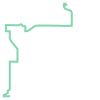

In [12]:
#test plot 
sac.geometry.iloc[2]


In [13]:
display(sac.shape)
display(sac.head(3))

(393, 8)

,key,source_record_id,name,route_id,shape_id,month,year,geometry
74,92ee64d95ea83c42a7922ae020226a66,recbzZQUIdMmFvm1r,Sacramento Schedule,213,45439,4,2023,"LINESTRING (-121.43869 38.52790, -121.43870 38..."
122,efb3865f306856498fc37d50203b2590,recbzZQUIdMmFvm1r,Sacramento Schedule,102,45972,8,2023,None
142,4def6187dada1c5406da712ebc6ffd53,recbzZQUIdMmFvm1r,Sacramento Schedule,019,45281,4,2023,"LINESTRING (-121.39221 38.71502, -121.39220 38..."


In [14]:
sac_routes = sac['route_id'].unique()


In [15]:
len(sac_routes)

67

In [17]:
type(sac_routes)

numpy.ndarray

In [18]:
sac_routes

array(['213', '102', '019', '113', '056', '134', '015', '533', '138',
       '072', '011', 'F20', '246', '109', '061', '086', '062', '177',
       '205', '212', '087', '228', '106', '084', '038', '210', '252',
       '161', '227', '033', '248', '206', '021', '30', '124', '088',
       '142', '507', '255', '025', '103', '030', '175', '013', '075',
       'F10', '214', '067', '211', '215', '082', '247', '226', '129',
       '519', '078', '051', '093', '068', '023', '10', '026', '176',
       '137', '081', '001', '105'], dtype=object)

## Next Steps

for every `name` and `route_id` in routes, need to see if each row is the same or not. Need to identify any variation in the routes. 



---

Trying to use a loop that will create a df for every route_id in sac_routes. but would need to do this for every `name` in the `fct_monthly_routes` df eventually?


In [16]:
#empty dictionary
sac_sub_route_ids = {}

#each element in sac_routes will be called route.
#for each route in sac_routes, query each row related to that route.(where ever you use the variable route, go 1-by-1 the differnet
#then, create a dataframe for each route and place it into the dictionary sub_dataframes
for route in sac_routes:
    sub_df = sac[sac['route_id'] == route]
    sac_sub_route_ids[route] = sub_df

In [19]:
len(sac_sub_route_ids)

67

In [20]:
type(sac_sub_route_ids)

dict

In [21]:
#testing dictionary with route 23 and 88
sac_sub_route_ids['023']

,key,source_record_id,name,route_id,shape_id,month,year,geometry
7077,aaecd8ed8b3b2d9a02ca274610d5ea4c,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45904,7,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."
7762,d80d73174d1d318341a7af73a6fdc452,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45286,5,2023,None
11058,1127c9acaecd57fd9543132998a72e3e,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45286,4,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."
11983,f90f1ad42b05640b35bf145497eedaee,recbzZQUIdMmFvm1r,Sacramento Schedule,023,46184,9,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."
15091,7f6cb56be4ebd83a3ec2e93e6a927d24,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45904,6,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."
16414,d04bc10c78b62fe6421c6eb28d509b78,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45904,8,2023,None


---

In [23]:
#list of unique route names from initial df
route_names = df['name'].unique()


In [24]:
#new loop that creates a dictionary of each unique schedule name with all its routes.
sub_route_name = {}

for name in route_names:
    sub_df2 = df[df['name'] == name]
    sub_route_name[name] = sub_df2
    

In [25]:
#test to see if new dictionary works
sub_route_name['Auburn Schedule']

,key,source_record_id,name,route_id,shape_id,month,year,pt_array
11416,5c0def64a3d9751f792ecc19e949d873,recPN6fJseWncWhDZ,Auburn Schedule,32372,p_1303321,6,2023,"[POINT(-121.082834 38.903344), POINT(-121.0828..."
12788,8b059c32e018998e842e4ef8ebbaeba2,recPN6fJseWncWhDZ,Auburn Schedule,32372,p_1303321,7,2023,"[POINT(-121.082834 38.903344), POINT(-121.0828..."
14521,2df5ab67da33b50d55e1bea697c90669,recPN6fJseWncWhDZ,Auburn Schedule,32372,p_1303321,9,2023,"[POINT(-121.082834 38.903344), POINT(-121.0828..."
15081,0d50ec3d4d59808aaacede3261691f7f,recPN6fJseWncWhDZ,Auburn Schedule,32372,p_1303321,8,2023,"[POINT(-121.082834 38.903344), POINT(-121.0828..."
19901,7f2990f969db2d363954feefb54a3134,recPN6fJseWncWhDZ,Auburn Schedule,32372,p_1303321,5,2023,"[POINT(-121.082834 38.903344), POINT(-121.0828..."
20412,d4a1fd712ec226a51120b701119508cf,recPN6fJseWncWhDZ,Auburn Schedule,32372,p_1303321,4,2023,"[POINT(-121.082834 38.903344), POINT(-121.0828..."
24062,d8f952c0d2e81564c71be5846e408212,recPN6fJseWncWhDZ,Auburn Schedule,32372,p_1303321,4,2023,[]


## Now I have `sac_sub_route_ids` and `sub_route_name` dictionaries

Examples of some noteable routes with slight variations over time.

In [26]:
#General observations for Sacramento Schedule: 
#shape_id changes every month. 
#pt_array changes every month, however, did get a warning upon initial query of data so may need to review query to account for geodata
#Month 4 has the point geom data

display(sac_sub_route_ids['088'])
display(sac_sub_route_ids['023'])
display(sac_sub_route_ids['105'])
display(sac_sub_route_ids['F20'])
display(sac_sub_route_ids['215'])

,key,source_record_id,name,route_id,shape_id,month,year,geometry
2036,07cfdab6c723e78bd2e0ec521e83c866,recbzZQUIdMmFvm1r,Sacramento Schedule,088,45966,8,2023,None
4087,190d4849a227aa1d64cb722e9eac60b9,recbzZQUIdMmFvm1r,Sacramento Schedule,088,45966,6,2023,"LINESTRING (-121.49172 38.57987, -121.49158 38..."
16841,22ca7af1d721d8e2b5d2be701162a697,recbzZQUIdMmFvm1r,Sacramento Schedule,088,45966,7,2023,"LINESTRING (-121.49172 38.57987, -121.49158 38..."
18863,fc4aecdbb2e90697aaca21929881da0c,recbzZQUIdMmFvm1r,Sacramento Schedule,088,45350,4,2023,"LINESTRING (-121.49172 38.57987, -121.49158 38..."
19857,559586f993036a5d2aba23bbddb5645f,recbzZQUIdMmFvm1r,Sacramento Schedule,088,45350,5,2023,None
21220,77f69afad316e4e3c13edb6c84e6bbd4,recbzZQUIdMmFvm1r,Sacramento Schedule,088,46248,9,2023,"LINESTRING (-121.49172 38.57987, -121.49158 38..."


,key,source_record_id,name,route_id,shape_id,month,year,geometry
7077,aaecd8ed8b3b2d9a02ca274610d5ea4c,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45904,7,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."
7762,d80d73174d1d318341a7af73a6fdc452,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45286,5,2023,None
11058,1127c9acaecd57fd9543132998a72e3e,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45286,4,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."
11983,f90f1ad42b05640b35bf145497eedaee,recbzZQUIdMmFvm1r,Sacramento Schedule,023,46184,9,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."
15091,7f6cb56be4ebd83a3ec2e93e6a927d24,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45904,6,2023,"LINESTRING (-121.26715 38.67912, -121.26712 38..."
16414,d04bc10c78b62fe6421c6eb28d509b78,recbzZQUIdMmFvm1r,Sacramento Schedule,023,45904,8,2023,None


,key,source_record_id,name,route_id,shape_id,month,year,geometry
12260,2831d45da95012846fec96c60672fb79,recbzZQUIdMmFvm1r,Sacramento Schedule,105,45976,7,2023,"LINESTRING (-121.46741 38.48333, -121.46743 38..."
16525,ef38344144bcacc0b257941a4322b01e,recbzZQUIdMmFvm1r,Sacramento Schedule,105,45975,8,2023,None
18436,4018359b844e81c2960f0248cc071bc8,recbzZQUIdMmFvm1r,Sacramento Schedule,105,46258,9,2023,"LINESTRING (-121.46741 38.48333, -121.46743 38..."
18854,59ef04d42732bd19260312593f2c7a92,recbzZQUIdMmFvm1r,Sacramento Schedule,105,45359,4,2023,"LINESTRING (-121.39027 38.46876, -121.39027 38..."
20881,4cbfc3213874266d76ce4a2699894f0c,recbzZQUIdMmFvm1r,Sacramento Schedule,105,45360,5,2023,None
23279,4db05d287614f4365277f2e0dd2e76cd,recbzZQUIdMmFvm1r,Sacramento Schedule,105,45975,6,2023,"LINESTRING (-121.39027 38.46876, -121.39027 38..."


,key,source_record_id,name,route_id,shape_id,month,year,geometry
867,a391eeb003f1286e3e83d2460d4b2c88,recbzZQUIdMmFvm1r,Sacramento Schedule,F20,46164,8,2023,None
8407,87a3f535201f3e670f4c0d362c28d1f0,recbzZQUIdMmFvm1r,Sacramento Schedule,F20,45548,5,2023,None
8705,4f4985564ae952024f79f44eed85362e,recbzZQUIdMmFvm1r,Sacramento Schedule,F20,46446,9,2023,"LINESTRING (-121.10389 38.65637, -121.10401 38..."
20929,a208640fbeb8878131cc6fe84b093cfa,recbzZQUIdMmFvm1r,Sacramento Schedule,F20,46164,6,2023,"LINESTRING (-121.10389 38.65637, -121.10401 38..."
21231,06ccf4cc80031f640f92eb083e3d6934,recbzZQUIdMmFvm1r,Sacramento Schedule,F20,46164,7,2023,"LINESTRING (-121.10389 38.65637, -121.10401 38..."
21782,2ed9e87018bcd053ef2ae87d3ebd7211,recbzZQUIdMmFvm1r,Sacramento Schedule,F20,45548,4,2023,"LINESTRING (-121.10389 38.65637, -121.10401 38..."


,key,source_record_id,name,route_id,shape_id,month,year,geometry
4956,cbb7791d0bb494668b06fc07a94f4c66,recbzZQUIdMmFvm1r,Sacramento Schedule,215,46341,9,2023,"LINESTRING (-121.44135 38.56057, -121.44199 38..."
7274,391282f0af7e612a0574c68ca695dac0,recbzZQUIdMmFvm1r,Sacramento Schedule,215,45443,4,2023,"LINESTRING (-121.44135 38.56057, -121.44199 38..."
12477,3b62b4ca009901a03bb9220f0861bdba,recbzZQUIdMmFvm1r,Sacramento Schedule,215,46059,7,2023,"LINESTRING (-121.44135 38.56057, -121.44199 38..."
16656,a982b3de1495893955d0744b4dbfaab7,recbzZQUIdMmFvm1r,Sacramento Schedule,215,46059,6,2023,"LINESTRING (-121.44135 38.56057, -121.44199 38..."
18992,ddffcda1e8b68e51520f39a0e8c27dee,recbzZQUIdMmFvm1r,Sacramento Schedule,215,46059,8,2023,None
19250,0f363ffa5be5b8eb4f2e64a04541cc9a,recbzZQUIdMmFvm1r,Sacramento Schedule,215,45443,5,2023,None


In [27]:
#test to see other route names
#other route names have more point geometry than Sacramento.
display(sub_route_name['Santa Cruz Schedule'])
display(sub_route_name['Merced Schedule'])
display(sub_route_name['San Diego Schedule'])
display(sub_route_name['Roseville Schedule'])

,key,source_record_id,name,route_id,shape_id,month,year,pt_array
205,668dfa05fc29db0d3f224857160e7a89,recpLgqMr7Y888HmN,Santa Cruz Schedule,10,shp-10-02,6,2023,"[POINT(-122.024574 36.971077), POINT(-122.0245..."
319,706aaf670bc0e2af7c58bf0b850d33a5,recpLgqMr7Y888HmN,Santa Cruz Schedule,72W,shp-72W-51,7,2023,"[POINT(-121.806686 36.988743), POINT(-121.8066..."
492,dc9ed4ec165c70c88d4428587efc3ffa,recpLgqMr7Y888HmN,Santa Cruz Schedule,71,shp-71-07,4,2023,"[POINT(-122.024475 36.970616), POINT(-122.0244..."
1200,05f23d59fc105d0ff6eb4de23cdea079,recpLgqMr7Y888HmN,Santa Cruz Schedule,55,shp-55-01,8,2023,"[POINT(-121.966098 36.975686), POINT(-121.9661..."
1546,da62c74df3c861f2b692f7faa52324b1,recpLgqMr7Y888HmN,Santa Cruz Schedule,69A,shp-69A-01,8,2023,"[POINT(-122.024475 36.970615), POINT(-122.0242..."
...,...,...,...,...,...,...,...,...
23285,3a2a04b4c1c728bd133fc107f8443151,recpLgqMr7Y888HmN,Santa Cruz Schedule,68,shp-68-51,9,2023,"[POINT(-121.966209 36.975433), POINT(-121.9659..."
23353,bb45e047a72fe982a868d1fca2f607a1,recpLgqMr7Y888HmN,Santa Cruz Schedule,71,shp-71-52,7,2023,"[POINT(-121.760223 36.909775), POINT(-121.7601..."
23981,b3564c30647cd3789a51627d067f5375,recpLgqMr7Y888HmN,Santa Cruz Schedule,35E,shp-35E-52,6,2023,[]
23987,93eb936ffc1ed72543205613ca7bfa11,recpLgqMr7Y888HmN,Santa Cruz Schedule,72W,shp-72W-01,9,2023,"[POINT(-121.760071 36.909863), POINT(-121.7601..."


,key,source_record_id,name,route_id,shape_id,month,year,pt_array
295,ee5c4ea6b6be52852af0a054232d40a4,reck9IsndFO0GtbQD,Merced Schedule,1206,p_3388,9,2023,"[POINT(-120.4881804 37.30196936), POINT(-120.4..."
804,7e83a9bcf1bbff8365e707ef800d65bf,reck9IsndFO0GtbQD,Merced Schedule,1201,p_111317,9,2023,"[POINT(-120.488108344 37.301915396), POINT(-12..."
1050,49a58177bf7803a9e1890348594a687e,reck9IsndFO0GtbQD,Merced Schedule,1212,p_3398,4,2023,"[POINT(-120.488200486 37.301777334), POINT(-12..."
1203,bc440ccb5ced671ee9ea4a9efe511872,reck9IsndFO0GtbQD,Merced Schedule,74426,p_1425538,4,2023,"[POINT(-120.487296 37.30166), POINT(-120.48700..."
1370,2854a583f0638b47919cd6059afcebae,reck9IsndFO0GtbQD,Merced Schedule,1206,p_3388,5,2023,"[POINT(-120.4881804 37.30196936), POINT(-120.4..."
...,...,...,...,...,...,...,...,...
22424,551fc57382c6ef49ea7cc218a10bb3a0,reck9IsndFO0GtbQD,Merced Schedule,1208,p_1425548,5,2023,"[POINT(-120.73366 37.385471), POINT(-120.73366..."
22825,a3fa07beadbfc32d9d58dc01d753626c,reck9IsndFO0GtbQD,Merced Schedule,1196,p_111309,4,2023,"[POINT(-120.610352 37.341354), POINT(-120.6101..."
23106,279f24ca784528e610d46778feffb2f2,reck9IsndFO0GtbQD,Merced Schedule,1207,p_3428,9,2023,"[POINT(-120.42700784 37.365634899), POINT(-120..."
23682,2a411af4ac2486e4576973f4731c7bc4,reck9IsndFO0GtbQD,Merced Schedule,1207,p_3428,7,2023,"[POINT(-120.42700784 37.365634899), POINT(-120..."


,key,source_record_id,name,route_id,shape_id,month,year,pt_array
3,377aed581fb7919d79846c244fe0a8d1,recfZ9iWkptccoONX,San Diego Schedule,967,S2_967_9_54,8,2023,"[POINT(-117.10739136 32.66163254), POINT(-117...."
32,400ef5387b4e8088392502d0bd870f09,recfZ9iWkptccoONX,San Diego Schedule,905,905_3_99,9,2023,"[POINT(-116.94038391 32.5532608), POINT(-116.9..."
68,62d88a8e8b34b0fe738f53f648bfe2a6,recfZ9iWkptccoONX,San Diego Schedule,8,8_1_66,9,2023,"[POINT(-117.21357727 32.80531311), POINT(-117...."
85,393ae16672e92f918beeecc10730f238,recfZ9iWkptccoONX,San Diego Schedule,110,S2_110_1_18,8,2023,"[POINT(-117.17105103 32.90517426), POINT(-117...."
101,da26a5af1ac3fa121649e1e1d83f4622,recfZ9iWkptccoONX,San Diego Schedule,891,S2_891_3_12,7,2023,"[POINT(-116.3756485 33.25683594), POINT(-116.3..."
...,...,...,...,...,...,...,...,...
24008,19b6b075bc2977e4f502fe4ad5be1cb5,recfZ9iWkptccoONX,San Diego Schedule,933,933_9_63,9,2023,"[POINT(-117.06627655 32.56989288), POINT(-117...."
24148,931d0581990b5686603c0ab638aff5d2,recfZ9iWkptccoONX,San Diego Schedule,44,S2_44_0_73,8,2023,"[POINT(-117.19927216 32.75484085), POINT(-117...."
24250,5171a9dc63adb71b692bc2afb270e172,recfZ9iWkptccoONX,San Diego Schedule,201,201_9_29,4,2023,"[POINT(-117.213398 32.868565), POINT(-117.2133..."
24253,52686d577fcc1f732e38dd21a7c42b67,recfZ9iWkptccoONX,San Diego Schedule,510,510_1_348,9,2023,"[POINT(-117.21403503 32.86920547), POINT(-117...."


,key,source_record_id,name,route_id,shape_id,month,year,pt_array
13,83f83b0e3539c7e79feb696a72599b5c,rec90jC43naXJz9lr,Roseville Schedule,10_PM,38256,7,2023,"[POINT(-121.258986 38.759161), POINT(-121.2583..."
61,9b9acd6bf7bbd0509ac2e93e62ad69a8,rec90jC43naXJz9lr,Roseville Schedule,9_AM,38273,6,2023,"[POINT(-121.335359 38.767776), POINT(-121.3354..."
530,ddab2619e6adfea366caaff641f42fa1,rec90jC43naXJz9lr,Roseville Schedule,2_AM,38257,4,2023,"[POINT(-121.309928 38.75917), POINT(-121.30992..."
646,40e195cff6b79ca580d6fe2ae4eeab02,rec90jC43naXJz9lr,Roseville Schedule,6_PM,38267,6,2023,"[POINT(-121.486544 38.578468), POINT(-121.4867..."
1078,c49bfa3afb37b82a8b201ca6497a61f8,rec90jC43naXJz9lr,Roseville Schedule,7_PM,38269,8,2023,"[POINT(-121.264939 38.748362), POINT(-121.2646..."
...,...,...,...,...,...,...,...,...
23159,07576196f50c30d3bd7e53c353c1f696,rec90jC43naXJz9lr,Roseville Schedule,3_AM,38259,7,2023,"[POINT(-121.309928 38.75917), POINT(-121.30992..."
23562,4675e889867614f8c3bc853555ca9ace,rec90jC43naXJz9lr,Roseville Schedule,3_AM,38259,8,2023,"[POINT(-121.309928 38.75917), POINT(-121.30992..."
23616,c24d0e8274875591be92599f6da00b45,rec90jC43naXJz9lr,Roseville Schedule,F,38288,8,2023,"[POINT(-121.264939 38.748362), POINT(-121.2646..."
23819,78df19180c6e97e445dbc23a2990772d,rec90jC43naXJz9lr,Roseville Schedule,M,38292,5,2023,"[POINT(-121.271435 38.772103), POINT(-121.2713..."


In [28]:
import importlib

importlib.reload(segment_speed_utils)
from segment_speed_utils.project_vars import SCHED_GCS, analysis_date

NameError: name 'segment_speed_utils' is not defined